# ** Описание **

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 1000
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [3]:
# def to_utf8(text):
#     if isinstance(text, unicode): text = text.encode('utf8')
#     return text

# def convert2unicode(f):
#     def tmp(text):
#         if not isinstance(text, unicode): text = text.decode('utf8')
#         return f(text)
#     return tmp

# def convert2lower(f):
#     def tmp(text):        
#         return f(text.lower())
#     return tmp

# #P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [971]:
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]
        
import nltk
nltk.download("stopwords")
#--------#

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    text = " ".join(tokens)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Основная функция, которая вызывается для преобразования html в список слов

In [972]:
def html2word(raw_html, to_text=html2text, tokenizer=preprocess_text):
    return tokenizer(to_text(raw_html).lower())

def html2word1(raw_html, to_text=html2text, tokenizer=pymorphy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [973]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [182]:
rus_docs = []
htmls = []
input_file_name = 'kaggle_train_data_tab.csv'

global LAST_HTML
with gzip.open(input_file_name, mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
    headers = input_file.readline()
    for i, line in enumerate(input_file):
        trace(i)
        parts = line.strip().split('\t')
        pageInb64 = parts[3]
        html_data = base64.b64decode(pageInb64)
        try:
            html_data = html_data.decode('utf8')
        except:
            html_data = html_data.decode('latin1')
        htmls.append(html_data)
        rus_docs.append(html2word(html_data))
    trace(i, 1)

14:24:29 INFO:Complete items 00000
14:27:46 INFO:Complete items 01000
14:29:02 INFO:Complete items 02000
14:31:12 INFO:Complete items 03000
14:35:14 INFO:Complete items 04000
14:38:36 INFO:Complete items 05000
14:40:15 INFO:Complete items 06000
14:46:12 INFO:Complete items 07000
14:46:15 INFO:Complete items 07043


In [11]:
len(htmls)

7044

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [1146]:
tfidf_vec = TfidfVectorizer(min_df=0.001)
doc_matrix_html = tfidf_vec.fit_transform(htmls)

In [206]:
doc_matrix_html.shape

(7044, 92876)

In [1147]:
tfidf_vec_rus = TfidfVectorizer(min_df=0.001)
doc_matrix_html_rus = tfidf_vec_rus.fit_transform(rus_docs)

In [505]:
doc_matrix_html_rus.shape

(7044, 44882)

In [1001]:
import bz2
import numpy as np

def calc_features(url, html_data, i):
    words = list(html2word1(html_data))
    words_num = len(words)
    avg_word_len = np.mean(np.array([len(word) for word in words]))
    title_words = re.search(r'(?<=\<title>)(.*?)(?=\</title>)', html_data)
    title_words_num = 0
    if title_words:
        title_words = title_words.group(1).split(' ')
        title_words_num = len([word for word in title_words if len(word)])
    anchor_words = re.search(r'(?<=\<body>)(.*?)(?=\</a>)', html_data)
    anchor_words_num = 0
    if anchor_words:
        anchor_words = anchor_words.group(1).split(' ')
        anchor_words_num = len([word for word in anchor_words if len(word)])
    keywords = re.search(r'(?<=\"[Kk]eywords" content=")(.*?)(?=\")', html_data)
    keys = None
    if keywords:
        keys = keywords.group(1).split(' ')
        keywords = preprocess_text(" ".join([word for word in keys if len(word)]))
    html = str.encode(html_data)
    comp_html = bz2.compress(html)
    after = len(comp_html)
    before = len(html)
    compression_level1 = before / after
    comp_html = gzip.compress(html)
    after = len(comp_html)
    before = len(html)
    compression_level2 = before / after
    
    return [len(words), avg_word_len, title_words_num, anchor_words_num, 
            compression_level2, keywords, keys, title_words, anchor_words, compression_level1]

In [975]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    global LAST_HTML
    with gzip.open(input_file_name, mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data, i)            
            yield DocItem(url_id, mark, url, features)
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name,  mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [1002]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv'
# TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

# train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))
train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))
# ololo = load_csv(TRAIN_DATA_FILE, calc_features)

14:13:18 INFO:Complete items 00000
14:13:40 INFO:Complete items 01000
14:13:56 INFO:Complete items 02000
14:14:14 INFO:Complete items 03000
14:14:32 INFO:Complete items 04000
14:14:58 INFO:Complete items 05000
14:15:16 INFO:Complete items 06000
14:15:37 INFO:Complete items 07000
14:15:37 INFO:Complete items 07043


CPU times: user 2min 4s, sys: 5.97 s, total: 2min 10s
Wall time: 2min 19s


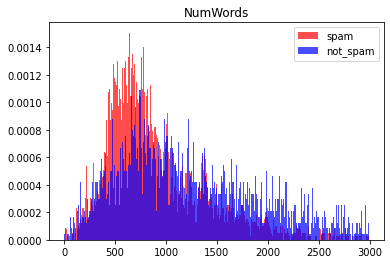

In [17]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

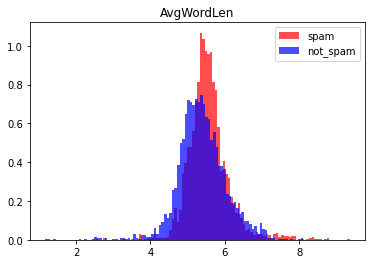

In [57]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

In [60]:
len([obj for obj in train_docs if obj.features[2]])

6094

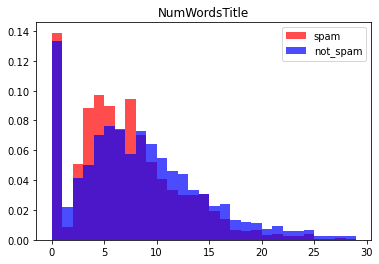

In [58]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать

In [17]:
import numpy as np

y = np.array([doc[1] for doc in train_docs])

In [1148]:
from sklearn.linear_model import LogisticRegression
import scipy

features_num = 3

X_feat = np.zeros((doc_matrix_html.shape[0], features_num)).astype('float')
X_free = np.zeros((doc_matrix_html.shape[0], 1)).astype('float')
X_down = np.zeros((doc_matrix_html.shape[0], 1)).astype('float')
for i in range(doc_matrix_html.shape[0]):
    X_feat[i][0] = train_docs[i].features[1]
    X_feat[i][1] = train_docs[i].features[3]
    X_feat[i][2] = train_docs[i].features[4]

In [993]:
key_feat = [] # ключевые слова
title = [] # заголовок
anchor = [] # анкоры
X_links = np.zeros((doc_matrix_html.shape[0], 1)) # количество ссылок
X_unique = np.zeros((doc_matrix_html.shape[0], 1)) # количество уникальных ссылок
X_nl = np.zeros((doc_matrix_html.shape[0], 1)) # количество сочетаний букв и цифр
for i in range(doc_matrix_html.shape[0]):
    X_num[i] = len(rus_docs[i].split(' '))
    if train_docs[i].features[5] is None:
        key_feat.append('')
    else:
        key_feat.append(train_docs[i].features[5])
    if train_docs[i].features[7] is None:
        title.append('')
    else:
        title.append(' '.join(train_docs[i].features[7]))
    if train_docs[i].features[8] is None:
        anchor.append('')
    else:
        anchor.append(' '.join(train_docs[i].features[8]))
    html_words = html2text(htmls[i])
    ix = 0
    count = -1
    urls = []
    while ix != -1:
        ix = html_words.find("www", ix + 1)
        url = html_words.find(".", ix + 4)
        if ix != -1:
            urls.append(html_words[ix + 4:url])
        count += 1
    X_links[i] = count
    X_unique[i] = np.unique(np.array(urls)).size
    for word in htmls[i].split(' '):
        f1 = False
        word = word.lower()
        f2 = word.islower()
        for letter in word:
            if letter.isdigit():
                f1 = True
                break
        if f1 & f2:
            X_nl[i] += 1
    
key_tf = TfidfVectorizer()
X_key = key_tf.fit_transform(key_feat)
X_key_imp = X_key.max(axis=1)

title_tf = TfidfVectorizer()
X_title = title_tf.fit_transform(title)

anchor_tf = TfidfVectorizer()
X_anchor = anchor_tf.fit_transform(anchor)

In [1149]:
X = scipy.sparse.hstack([X_nl, X_key, X_feat, X_links, X_unique,
                        X_title, X_anchor, X_key_imp,
                         doc_matrix_html_rus * 10, doc_matrix_html * 10]).tocsr()

train_X = X[:int(doc_matrix_html.shape[0] * 0.3)]
train_y = y[:int(doc_matrix_html.shape[0] * 0.3)]

clf2 = LogisticRegression()
clf2.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [915]:
from sklearn.metrics import f1_score

In [1150]:
valid = X[int(doc_matrix_html.shape[0] * 0.3):]
preds = clf2.predict(valid)
y_val = y[int(y.shape[0] * 0.3):]
f1_score(y_val, preds, 'weighted')

0.9784296807592752

In [361]:
htmls_test = []
rus_docs_test = []
input_file_name = 'kaggle_test_data_tab.csv'

global LAST_HTML
with gzip.open(input_file_name, mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
    headers = input_file.readline()
    for i, line in enumerate(input_file):
        trace(i)
        parts = line.strip().split('\t')
        pageInb64 = parts[3]
        html_data = base64.b64decode(pageInb64)
        try:
            html_data = html_data.decode('utf8')
        except:
            html_data = html_data.decode('latin1')
        htmls_test.append(html_data)
        rus_docs_test.append(html2word(html_data))
    trace(i, 1)

15:42:30 INFO:Complete items 00000
15:45:17 INFO:Complete items 01000
15:47:23 INFO:Complete items 02000
15:49:14 INFO:Complete items 03000
15:50:51 INFO:Complete items 04000
15:52:37 INFO:Complete items 05000
15:54:43 INFO:Complete items 06000
15:56:16 INFO:Complete items 07000
15:58:02 INFO:Complete items 08000
15:59:31 INFO:Complete items 09000
16:01:36 INFO:Complete items 10000
16:03:03 INFO:Complete items 11000
16:04:31 INFO:Complete items 12000
16:05:51 INFO:Complete items 13000
16:08:21 INFO:Complete items 14000
16:10:04 INFO:Complete items 15000
16:12:09 INFO:Complete items 16000
16:12:16 INFO:Complete items 16038


In [362]:
tf_rus = TfidfVectorizer(min_df=0.001)
all_htmls_rus = []
all_htmls_rus.extend(rus_docs)
all_htmls_rus.extend(rus_docs_test)
X_all_rus = tf_rus.fit_transform(all_htmls_rus)

In [811]:
tf = TfidfVectorizer(min_df=0.001)
all_htmls = []
all_htmls.extend(htmls)
all_htmls.extend(htmls_test)
X_all = tf.fit_transform(all_htmls)

In [277]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv'
test_docs = list(load_csv(TEST_DATA_FILE, calc_features))
ids = [obj[0] for obj in test_docs]

15:14:09 INFO:Complete items 00000
15:14:32 INFO:Complete items 01000
15:14:51 INFO:Complete items 02000
15:15:09 INFO:Complete items 03000
15:15:26 INFO:Complete items 04000
15:15:41 INFO:Complete items 05000
15:16:00 INFO:Complete items 06000
15:16:15 INFO:Complete items 07000
15:16:35 INFO:Complete items 08000
15:16:51 INFO:Complete items 09000
15:17:12 INFO:Complete items 10000
15:17:27 INFO:Complete items 11000
15:17:43 INFO:Complete items 12000
15:17:57 INFO:Complete items 13000
15:18:13 INFO:Complete items 14000
15:18:30 INFO:Complete items 15000
15:18:47 INFO:Complete items 16000
15:18:48 INFO:Complete items 16038


In [1153]:
features_num = 3

X_feat_test = np.zeros((len(test_docs), features_num)).astype('float')
for i in range(len(test_docs)):
    X_feat_test[i][0] = test_docs[i].features[1]
    X_feat_test[i][1] = test_docs[i].features[3]
    X_feat_test[i][2] = test_docs[i].features[4]
    
X_feat_all = np.vstack([X_feat, X_feat_test])

In [1156]:
all_keys = keys
all_titles = title
all_anchors = anchor
X_links_test= np.zeros((len(test_docs), 1))
X_unique_test = np.zeros((len(test_docs), 1))
X_nl_test = np.zeros((len(test_docs), 1))

for i in range(len(test_docs)):
    if test_docs[i].features[5] is None:
        all_keys.append('')
    else:
        all_keys.append(test_docs[i].features[5])
    if test_docs[i].features[7] is None:
        all_titles.append('')
    else:
        all_titles.append(' '.join(test_docs[i].features[7]))
    if test_docs[i].features[8] is None:
        all_anchors.append('')
    else:
        all_anchors.append(' '.join(test_docs[i].features[8]))
    html_words = html2text(all_htmls[i + doc_matrix_html.shape[0]])
    ix = 0
    count = -1
    urls = []
    while ix != -1:
        ix = html_words.find("www", ix + 1)
        url = html_words.find(".", ix + 4)
        if ix != -1:
            urls.append(html_words[ix + 4:url])
        count += 1
    X_links_test[i] = count
    X_unique_test[i] = np.unique(np.array(urls)).size
    for word in all_htmls[i + doc_matrix_html.shape[0]].split(' '):
        f1 = False
        word = word.lower()
        f2 = word.islower()
        for letter in word:
            if letter.isdigit():
                f1 = True
                break
        if f1 & f2:
            X_nl_test[i] += 1
    
key_tf_all = TfidfVectorizer()
X_key_all = key_tf_all.fit_transform(all_keys)
X_key_imp_all = X_key_all.max(axis=1)
title_tf_all = TfidfVectorizer()
X_title_all = title_tf_all.fit_transform(all_titles)
anchor_tf_all = TfidfVectorizer()
X_anchor_all = anchor_tf_all.fit_transform(all_anchors)

In [1161]:
X_unique_all = np.vstack([X_unique, X_unique_test])
X_links_all = np.vstack([X_links, X_links_test])
X_nl_all = np.vstack([X_nl, X_nl_test])
X1 = scipy.sparse.hstack([X_feat_all, X_key_all, X_nl_all, X_key_imp_all, X_links_all,
                          X_unique_all, X_title_all, X_anchor_all, X_all * 10, 
                          X_all_rus * 10]).tocsr()

In [1162]:
clf = LogisticRegression()
clf.fit(X1[:doc_matrix_html.shape[0]], y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [1163]:
with open('my_submission.csv', 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    preds_test = clf.predict(X1[doc_matrix_html.shape[0]:])
    for i in range(len(ids)):
        prediction = preds_test[i]
        writer.writerow([ids[i], int(prediction)])